Files already downloaded and verified
Files already downloaded and verified
1 :  0.29076624
2 :  0.40329766
3 :  0.47024179
4 :  0.5070064
5 :  0.5430948
6 :  0.57118714
7 :  0.5983171
8 :  0.61998874
9 :  0.64063513
10 :  0.6550151
11 :  0.66812074
12 :  0.6787805
13 :  0.68928033
14 :  0.699323
15 :  0.70850784
16 :  0.71668184
17 :  0.72407794
18 :  0.73123926
19 :  0.738114
20 :  0.7445464
21 :  0.75049037
22 :  0.7563639
23 :  0.76131964
24 :  0.76622754
25 :  0.7710321
26 :  0.77569085
27 :  0.78020436
28 :  0.7846409
29 :  0.7886487
30 :  0.7925874
31 :  0.79624957
32 :  0.799581
33 :  0.8028206
34 :  0.8059231
35 :  0.808999
36 :  0.8119115
37 :  0.8145237
38 :  0.8171163
39 :  0.81965977
40 :  0.82214355
41 :  0.82457024
42 :  0.8268634
43 :  0.82914513
44 :  0.83136034
45 :  0.83346295
46 :  0.8355303
47 :  0.83745486
48 :  0.8393586
49 :  0.84120524
50 :  0.8430222
51 :  0.84480274
52 :  0.8465387
53 :  0.8482504
54 :  0.849948
55 :  0.8515713
56 :  0.8531572
57 :  0.8547213

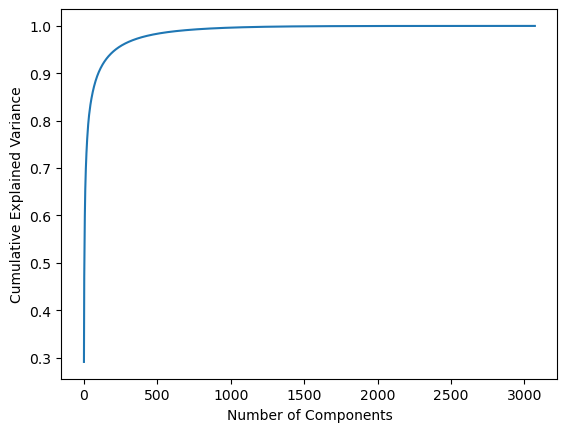

In [4]:
import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision import transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from time import time

random_state=42
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load CIFAR-10 data
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
test = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)

train_data, train_labels = next(iter(train))
test_data, test_labels = next(iter(test))

train_data = np.array(train_data.view(train_data.shape[0], -1))
train_labels = np.array(train_labels)
test_data = np.array(test_data.view(test_data.shape[0], -1))
test_labels = np.array(test_labels)
pca = PCA(random_state=random_state).fit(train_data)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
for i, var in enumerate(cumulative_variance):
    print(str(i+1), ': ',  str(var))
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [5]:
pca = PCA(0.9, random_state=random_state).fit(train_data)
print(f"PCA is complete with {pca.n_components_} components")
pca_train_data = pca.transform(train_data)
pca_test_data = pca.transform(test_data)

PCA is complete with 99 components


In [17]:
from sklearn.model_selection import ParameterGrid


param_grid = {
    "C": [[0.01, 0.1, 1]],
    "gamma": [['auto', 'scale', 0.1, 1, 10]],
    "kernel": [["rbf", "linear", "sigmoid"]],
    "decision_function_shape": [["ovo", "ovr"]],
    "coef0": [[0.0, 0.1, 0.5, 1.0]],
}

poly_params = {
    "C": [[0.01, 0.1, 1]],
    "gamma": [['auto', 'scale', 0.1, 1, 10]],
    "kernel": [['poly']],
    "degree": [[2, 3, 4, 5, 6]],
    "decision_function_shape": [["ovo", "ovr"]],
    "coef0": [[0.0, 0.1, 0.5, 1.0]],
}

param_grid_list = [param_grid, poly_params]

param_combinations = []

for params in param_grid_list:
    param_combinations.extend(list(ParameterGrid(params)))

num_samples_per_class = 500
num_classes = len(np.unique(train_labels))

new_samples = np.empty((num_samples_per_class * num_classes, train_data.shape[1]))
new_labels = np.empty(num_samples_per_class * num_classes, dtype=train_labels.dtype)

for class_label in range(num_classes):
    class_indices = np.where(train_labels == class_label)[0]
    selected_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
    new_samples[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class, :] = train_data[selected_indices, :]
    pca_new_samples = pca.transform(new_samples)
    new_labels[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class] = train_labels[selected_indices]

grid = GridSearchCV(SVC(), param_combinations, verbose=2, n_jobs=-1)
grid.fit(pca_new_samples, new_labels)

print(f"Best parameters set found: {grid.best_params_}")
print("Grid scores:")
means = grid.cv_results_["mean_test_score"]
stds = grid.cv_results_["std_test_score"]
means_fit_time = grid.cv_results_["mean_fit_time"]
stds_fit_time = grid.cv_results_["std_fit_time"]
for mean, std, mean_fit_time, std_fit_time, params in zip(
    means,
    stds,
    means_fit_time,
    stds_fit_time,
    grid.cv_results_["params"],
):
    print(
        "%0.3f (+/-%0.03f) for %r in %0.3f (+/-%0.03f)"
        % (mean, std * 2, params, mean_fit_time, std_fit_time * 2)
    )


Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Best parameters set found: {'C': 1, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'}
Grid scores:
0.146 (+/-0.021) for {'C': 0.01, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'rbf'} in 4.276 (+/-0.313)
0.367 (+/-0.036) for {'C': 0.01, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'linear'} in 3.073 (+/-0.470)
0.204 (+/-0.020) for {'C': 0.01, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'sigmoid'} in 4.211 (+/-0.194)
0.313 (+/-0.027) for {'C': 0.01, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'} in 3.975 (+/-0.143)
0.367 (+/-0.036) for {'C': 0.01, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'linear'} in 3.092 (+/-0.381)
0.247 (+/-0.031) for {'C': 0.01, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'sigmoid

In [21]:
from sklearn.model_selection import ParameterGrid


param_grid = {
    "C": [[1, 10, 100, 1000]],
    "gamma": [['auto', 'scale', 0.1, 1, 10]],
    "kernel": [["rbf", "sigmoid"]],
    "decision_function_shape": [["ovo", "ovr"]],
    "coef0": [[0.0, 0.1, 0.5, 1.0]],
}

poly_params = {
    "C": [[1, 10, 100, 1000]],
    "gamma": [['auto', 'scale', 0.1, 1, 10]],
    "kernel": [['poly']],
    "degree": [[2, 3, 4, 5, 6]],
    "decision_function_shape": [["ovo", "ovr"]],
    "coef0": [[0.0, 0.1, 0.5, 1.0]],
}

param_grid_list = [param_grid, poly_params]

param_combinations = []

for params in param_grid_list:
    param_combinations.extend(list(ParameterGrid(params)))

num_samples_per_class = 500
num_classes = len(np.unique(train_labels))

new_samples = np.empty((num_samples_per_class * num_classes, train_data.shape[1]))
new_labels = np.empty(num_samples_per_class * num_classes, dtype=train_labels.dtype)

for class_label in range(num_classes):
    class_indices = np.where(train_labels == class_label)[0]
    selected_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
    new_samples[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class, :] = train_data[selected_indices, :]
    pca_new_samples = pca.transform(new_samples)
    new_labels[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class] = train_labels[selected_indices]

grid = GridSearchCV(SVC(), param_combinations, verbose=2, n_jobs=-1)
grid.fit(pca_new_samples, new_labels)

print(f"Best parameters set found: {grid.best_params_}")
print("Grid scores:")
means = grid.cv_results_["mean_test_score"]
stds = grid.cv_results_["std_test_score"]
means_fit_time = grid.cv_results_["mean_fit_time"]
stds_fit_time = grid.cv_results_["std_fit_time"]
for mean, std, mean_fit_time, std_fit_time, params in zip(
    means,
    stds,
    means_fit_time,
    stds_fit_time,
    grid.cv_results_["params"],
):
    print(
        "%0.3f (+/-%0.03f) for %r in %0.3f (+/-%0.03f)"
        % (mean, std * 2, params, mean_fit_time, std_fit_time * 2)
    )


Fitting 5 folds for each of 1120 candidates, totalling 5600 fits
Best parameters set found: {'C': 1, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'}
Grid scores:
0.336 (+/-0.024) for {'C': 1, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'rbf'} in 4.918 (+/-1.310)
0.134 (+/-0.016) for {'C': 1, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'sigmoid'} in 2.990 (+/-0.482)
0.426 (+/-0.032) for {'C': 1, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'} in 4.206 (+/-0.992)
0.243 (+/-0.041) for {'C': 1, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'sigmoid'} in 2.627 (+/-0.709)
0.118 (+/-0.005) for {'C': 1, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'rbf'} in 4.263 (+/-0.613)
0.121 (+/-0.011) for {'C': 1, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'sigmoid'} in 2.910 (+/-1.059)
0.1

In [22]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    "decision_function_shape": ["ovo"],
    "tol": [1e-4, 1e-3, 1e-2],
    "probability": [True, False]
}


num_samples_per_class = 500
num_classes = len(np.unique(train_labels))

new_samples = np.empty((num_samples_per_class * num_classes, train_data.shape[1]))
new_labels = np.empty(num_samples_per_class * num_classes, dtype=train_labels.dtype)

for class_label in range(num_classes):
    class_indices = np.where(train_labels == class_label)[0]
    selected_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
    new_samples[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class, :] = train_data[selected_indices, :]
    pca_new_samples = pca.transform(new_samples)
    new_labels[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class] = train_labels[selected_indices]

grid = GridSearchCV(SVC(), param_grid, verbose=2, n_jobs=-1)
grid.fit(pca_new_samples, new_labels)

print(f"Best parameters set found: {grid.best_params_}")
print("Grid scores:")
means = grid.cv_results_["mean_test_score"]
stds = grid.cv_results_["std_test_score"]
means_fit_time = grid.cv_results_["mean_fit_time"]
stds_fit_time = grid.cv_results_["std_fit_time"]
for mean, std, mean_fit_time, std_fit_time, params in zip(
    means,
    stds,
    means_fit_time,
    stds_fit_time,
    grid.cv_results_["params"],
):
    print(
        "%0.3f (+/-%0.03f) for %r in %0.3f (+/-%0.03f)"
        % (mean, std * 2, params, mean_fit_time, std_fit_time * 2)
    )


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters set found: {'decision_function_shape': 'ovo', 'probability': True, 'tol': 0.01}
Grid scores:
0.432 (+/-0.032) for {'decision_function_shape': 'ovo', 'probability': True, 'tol': 0.0001} in 21.219 (+/-1.479)
0.432 (+/-0.032) for {'decision_function_shape': 'ovo', 'probability': True, 'tol': 0.001} in 20.702 (+/-1.849)
0.433 (+/-0.031) for {'decision_function_shape': 'ovo', 'probability': True, 'tol': 0.01} in 19.452 (+/-1.062)
0.432 (+/-0.032) for {'decision_function_shape': 'ovo', 'probability': False, 'tol': 0.0001} in 3.238 (+/-0.604)
0.432 (+/-0.032) for {'decision_function_shape': 'ovo', 'probability': False, 'tol': 0.001} in 2.912 (+/-0.434)
0.433 (+/-0.031) for {'decision_function_shape': 'ovo', 'probability': False, 'tol': 0.01} in 2.578 (+/-0.775)


In [4]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    "C": [0.01, 0.1, 1, 10, 50, 100],
    "gamma": ["scale", "auto", 0.1, 0.5, 1],
    "decision_function_shape": ["ovo", "ovr"],
    "tol": [1e-4, 1e-3, 1e-2],
    "probability": [True, False], 
    "random_state": [42]
}

num_samples_per_class = 500
num_classes = len(np.unique(train_labels))

new_samples = np.empty((num_samples_per_class * num_classes, train_data.shape[1]))
new_labels = np.empty(num_samples_per_class * num_classes, dtype=train_labels.dtype)

for class_label in range(num_classes):
    class_indices = np.where(train_labels == class_label)[0]
    selected_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
    new_samples[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class, :] = train_data[selected_indices, :]
    pca_new_samples = pca.transform(new_samples)
    new_labels[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class] = train_labels[selected_indices]

grid = GridSearchCV(SVC(), param_grid, verbose=2, n_jobs=-1)
grid.fit(pca_new_samples, new_labels)

print(f"Best parameters set found: {grid.best_params_}")
print("Grid scores:")
means = grid.cv_results_["mean_test_score"]
stds = grid.cv_results_["std_test_score"]
means_fit_time = grid.cv_results_["mean_fit_time"]
stds_fit_time = grid.cv_results_["std_fit_time"]
for mean, std, mean_fit_time, std_fit_time, params in zip(
    means,
    stds,
    means_fit_time,
    stds_fit_time,
    grid.cv_results_["params"],
):
    print(
        "%0.3f (+/-%0.03f) for %r in %0.3f (+/-%0.03f)"
        % (mean, std * 2, params, mean_fit_time, std_fit_time * 2)
    )


Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best parameters set found: {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'probability': True, 'random_state': 42, 'tol': 0.001}
Grid scores:
0.304 (+/-0.039) for {'C': 0.01, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'probability': True, 'random_state': 42, 'tol': 0.0001} in 31.781 (+/-1.305)
0.304 (+/-0.039) for {'C': 0.01, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'probability': True, 'random_state': 42, 'tol': 0.001} in 29.844 (+/-4.367)
0.304 (+/-0.039) for {'C': 0.01, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'probability': True, 'random_state': 42, 'tol': 0.01} in 27.370 (+/-0.298)
0.304 (+/-0.039) for {'C': 0.01, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'probability': False, 'random_state': 42, 'tol': 0.0001} in 4.220 (+/-0.193)
0.304 (+/-0.039) for {'C': 0.01, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'probability': False, 'random_state': 42, 'tol': 

In [22]:
num_samples_per_class = 500
num_classes = len(np.unique(train_labels))

new_samples = np.empty((num_samples_per_class * num_classes, train_data.shape[1]))
new_labels = np.empty(num_samples_per_class * num_classes, dtype=train_labels.dtype)

for class_label in range(num_classes):
    class_indices = np.where(train_labels == class_label)[0]
    selected_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
    new_samples[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class, :] = train_data[selected_indices, :]
    pca_new_samples = pca.transform(new_samples)
    new_labels[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class] = train_labels[selected_indices]
    
start_time = time()
model = SVC(C=10, decision_function_shape='ovo', random_state=42).fit(pca_new_samples, new_labels)
print("Training process (5000 the size of the mini batch): ", str(time() - start_time))
print(f'Mini-batch training set Accuracy: {100 * model.score(pca_new_samples, new_labels):.4f}%')
print(f'Whole training set Accuracy: {100 * model.score(pca_train_data, train_labels):.4f}%')
print(f'Test Accuracy: {100 * model.score(pca_test_data, test_labels):.4f}%')

Training process (5000 the size of the mini batch):  2.770853281021118
Mini-batch training set Accuracy: 97.4800%
Whole training set Accuracy: 49.1980%
Test Accuracy: 44.2200%


In [23]:
num_samples_per_class = 1000
num_classes = len(np.unique(train_labels))

new_samples = np.empty((num_samples_per_class * num_classes, train_data.shape[1]))
new_labels = np.empty(num_samples_per_class * num_classes, dtype=train_labels.dtype)

for class_label in range(num_classes):
    class_indices = np.where(train_labels == class_label)[0]
    selected_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
    new_samples[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class, :] = train_data[selected_indices, :]
    pca_new_samples = pca.transform(new_samples)
    new_labels[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class] = train_labels[selected_indices]
    
start_time = time()
model = SVC(C=10, decision_function_shape='ovo', random_state=42).fit(pca_new_samples, new_labels)
print("Training process (10000 the size of the mini batch): ", str(time() - start_time))
print(f'Mini-batch training set Accuracy: {100 * model.score(pca_new_samples, new_labels):.4f}%')
print(f'Whole training set Accuracy: {100 * model.score(pca_train_data, train_labels):.4f}%')
print(f'Test Accuracy with tolerance: {100 * model.score(pca_test_data, test_labels):.4f}%')

Training process (10000 the size of the mini batch):  10.014667510986328
Mini-batch training set Accuracy: 96.2700%
Whole training set Accuracy: 56.9020%
Test Accuracy with tolerance: 47.8200%


In [24]:
start_time = time()
model = SVC(C=10, decision_function_shape='ovo').fit(pca_train_data, train_labels)
print("Training process: ", str(time() - start_time))
print(f'Training set Accuracy: {100 * model.score(pca_train_data, train_labels):.4f}%')
print(f'Test Accuracy : {100 * model.score(pca_test_data, test_labels):.4f}%')

Training process:  423.3248574733734
Training set Accuracy: 92.1620%
Test Accuracy : 56.2400%


In [9]:
from sklearn.model_selection import ParameterGrid

param_grid = poly_params = {
    "C": [10, 50, 100],
    "gamma": ['auto', 'scale', 0.1, 1, 10],
    "kernel": ['poly'],
    "degree": [2, 3, 4, 5],
    "random_state" : [42],
    "decision_function_shape": ["ovo", "ovr"],
    "coef0": [0.0, 0.1, 0.5, 1.0],
    "decision_function_shape": ["ovo", "ovr"],
    "tol": [1e-4, 1e-3, 1e-2],
    "probability": [True, False], 
}

num_samples_per_class = 500
num_classes = len(np.unique(train_labels))

new_samples = np.empty((num_samples_per_class * num_classes, train_data.shape[1]))
new_labels = np.empty(num_samples_per_class * num_classes, dtype=train_labels.dtype)

for class_label in range(num_classes):
    class_indices = np.where(train_labels == class_label)[0]
    selected_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
    new_samples[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class, :] = train_data[selected_indices, :]
    pca_new_samples = pca.transform(new_samples)
    new_labels[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class] = train_labels[selected_indices]

grid = GridSearchCV(SVC(), param_grid, verbose=2, n_jobs=-1)
grid.fit(pca_new_samples, new_labels)

print(f"Best parameters set found: {grid.best_params_}")
print("Grid scores:")
means = grid.cv_results_["mean_test_score"]
stds = grid.cv_results_["std_test_score"]
means_fit_time = grid.cv_results_["mean_fit_time"]
stds_fit_time = grid.cv_results_["std_fit_time"]
for mean, std, mean_fit_time, std_fit_time, params in zip(
    means,
    stds,
    means_fit_time,
    stds_fit_time,
    grid.cv_results_["params"],
):
    print(
        "%0.3f (+/-%0.03f) for %r in %0.3f (+/-%0.03f)"
        % (mean, std * 2, params, mean_fit_time, std_fit_time * 2)
    )


Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best parameters set found: {'C': 10, 'coef0': 0.1, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'probability': True, 'random_state': 42, 'tol': 0.0001}
Grid scores:
0.350 (+/-0.039) for {'C': 10, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'probability': True, 'random_state': 42, 'tol': 0.0001} in 37.185 (+/-2.353)
0.350 (+/-0.039) for {'C': 10, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'probability': True, 'random_state': 42, 'tol': 0.001} in 29.417 (+/-5.648)
0.350 (+/-0.040) for {'C': 10, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'probability': True, 'random_state': 42, 'tol': 0.01} in 21.859 (+/-1.359)
0.350 (+/-0.039) for {'C': 10, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'auto', 'kernel': 'po

In [10]:
from sklearn.model_selection import ParameterGrid

param_grid = poly_params = {
    "C": [0.01, 0.1, 1],
    "gamma": ['auto', 'scale', 0.1, 1, 10],
    "kernel": ['poly'],
    "degree": [2, 3, 4, 5],
    "random_state" : [42],
    "decision_function_shape": ["ovo", "ovr"],
    "coef0": [0.0, 0.1, 0.5, 1.0],
    "tol": [1e-4, 1e-3, 1e-2],
    "probability": [True, False], 
}

num_samples_per_class = 500
num_classes = len(np.unique(train_labels))

new_samples = np.empty((num_samples_per_class * num_classes, train_data.shape[1]))
new_labels = np.empty(num_samples_per_class * num_classes, dtype=train_labels.dtype)

for class_label in range(num_classes):
    class_indices = np.where(train_labels == class_label)[0]
    selected_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
    new_samples[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class, :] = train_data[selected_indices, :]
    pca_new_samples = pca.transform(new_samples)
    new_labels[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class] = train_labels[selected_indices]

grid = GridSearchCV(SVC(), param_grid, verbose=2, n_jobs=-1)
grid.fit(pca_new_samples, new_labels)

print(f"Best parameters set found: {grid.best_params_}")
print("Grid scores:")
means = grid.cv_results_["mean_test_score"]
stds = grid.cv_results_["std_test_score"]
means_fit_time = grid.cv_results_["mean_fit_time"]
stds_fit_time = grid.cv_results_["std_fit_time"]
for mean, std, mean_fit_time, std_fit_time, params in zip(
    means,
    stds,
    means_fit_time,
    stds_fit_time,
    grid.cv_results_["params"],
):
    print(
        "%0.3f (+/-%0.03f) for %r in %0.3f (+/-%0.03f)"
        % (mean, std * 2, params, mean_fit_time, std_fit_time * 2)
    )


Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best parameters set found: {'C': 1, 'coef0': 0.5, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'probability': True, 'random_state': 42, 'tol': 0.0001}
Grid scores:
0.289 (+/-0.033) for {'C': 0.01, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'probability': True, 'random_state': 42, 'tol': 0.0001} in 15.450 (+/-0.488)
0.289 (+/-0.033) for {'C': 0.01, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'probability': True, 'random_state': 42, 'tol': 0.001} in 15.034 (+/-0.379)
0.290 (+/-0.033) for {'C': 0.01, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'probability': True, 'random_state': 42, 'tol': 0.01} in 14.678 (+/-0.116)
0.289 (+/-0.033) for {'C': 0.01, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'auto', 'kerne

In [25]:
num_samples_per_class = 500
num_classes = len(np.unique(train_labels))

new_samples = np.empty((num_samples_per_class * num_classes, train_data.shape[1]))
new_labels = np.empty(num_samples_per_class * num_classes, dtype=train_labels.dtype)

for class_label in range(num_classes):
    class_indices = np.where(train_labels == class_label)[0]
    selected_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
    new_samples[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class, :] = train_data[selected_indices, :]
    pca_new_samples = pca.transform(new_samples)
    new_labels[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class] = train_labels[selected_indices]
    
start_time = time()
model = SVC(C=1, kernel='poly', coef0=0.5, degree=3, decision_function_shape='ovo').fit(pca_new_samples, new_labels)
print("Training process (5000 the size of the mini batch): ", str(time() - start_time))
print(f'Mini-batch training set Accuracy: {100 * model.score(pca_new_samples, new_labels):.4f}%')
print(f'Whole training set Accuracy: {100 * model.score(pca_train_data, train_labels):.4f}%')
print(f'Test Accuracy: {100 * model.score(pca_test_data, test_labels):.4f}%')

Training process (5000 the size of the mini batch):  1.5385587215423584
Mini-batch training set Accuracy: 82.9400%
Whole training set Accuracy: 47.4580%
Test Accuracy: 43.6900%


In [6]:
num_samples_per_class = 1000
num_classes = len(np.unique(train_labels))

new_samples = np.empty((num_samples_per_class * num_classes, train_data.shape[1]))
new_labels = np.empty(num_samples_per_class * num_classes, dtype=train_labels.dtype)

for class_label in range(num_classes):
    class_indices = np.where(train_labels == class_label)[0]
    selected_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
    new_samples[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class, :] = train_data[selected_indices, :]
    pca_new_samples = pca.transform(new_samples)
    new_labels[class_label * num_samples_per_class : (class_label + 1) * num_samples_per_class] = train_labels[selected_indices]
    
start_time = time()
model = SVC(C=1, kernel='poly', coef0=0.5, degree=3, decision_function_shape='ovo').fit(pca_new_samples, new_labels)
print("Training process (10000 the size of the mini batch): ", str(time() - start_time))
print(f'Mini-batch training set Accuracy: {100 * model.score(pca_new_samples, new_labels):.4f}%')
print(f'Whole training set Accuracy: {100 * model.score(pca_train_data, train_labels):.4f}%')
print(f'Test Accuracy: {100 * model.score(pca_test_data, test_labels):.4f}%')

Training process (10000 the size of the mini batch):  5.8571343421936035
Mini-batch training set Accuracy: 80.6100%
Whole training set Accuracy: 53.4740%
Test Accuracy: 47.1300%


In [7]:
start_time = time()
model = SVC(C=1, kernel='poly', coef0=0.5, degree=3, decision_function_shape='ovo').fit(pca_train_data, train_labels)
print("Training process: ", str(time() - start_time))
print(f'Training set Accuracy: {100 * model.score(pca_train_data, train_labels):.4f}%')
print(f'Test Accuracy : {100 * model.score(pca_test_data, test_labels):.4f}%')

Training process:  293.58865761756897
Training set Accuracy: 74.9660%
Test Accuracy : 54.8500%
